# 05B — Scenario Stress Testing

**Purpose**: Shock analysis — how would portfolio react to major macro moves?

**Scenarios**:
- +10% Oil
- +100 bps US Rates
- −5% INR
- VIX spike to 35

This is real hedge fund discipline.

---

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

PROCESSED_PATH = Path('../data_processed')

# Load factor exposures
try:
    beta_df = pd.read_parquet(PROCESSED_PATH / 'sector_factor_betas.parquet')
    beta_pivot = pd.read_parquet(PROCESSED_PATH / 'factor_exposure_matrix.parquet')
    print(f"Loaded {len(beta_df)} sector-factor relationships")
except:
    print("Factor data not found. Run 05A first.")
    beta_df = pd.DataFrame()
    beta_pivot = pd.DataFrame()

Loaded 42 sector-factor relationships


## 1. Define Stress Scenarios

In [2]:
# Scenario definitions
STRESS_SCENARIOS = {
    'OIL_SHOCK': {
        'description': 'Brent crude +10%',
        'shocks': {'BRENT': 10, 'WTI': 10},  # % change
        'historical_example': 'Russia-Ukraine 2022',
        'expected_impact': 'Negative for importers, mixed for energy'
    },
    'US_RATE_HIKE': {
        'description': 'US 10Y yield +100 bps',
        'shocks': {'US10Y': 1.0, 'US10Y_Delta': 100},  # 100 bps
        'historical_example': '2022 Fed tightening',
        'expected_impact': 'EM outflows, IT hurt, Banks mixed'
    },
    'INR_DEPRECIATION': {
        'description': 'INR depreciates 5% vs USD',
        'shocks': {'DXY': 5, 'USDINR': 5},  # % change
        'historical_example': 'Taper tantrum 2013',
        'expected_impact': 'IT benefits, importers hurt'
    },
    'VIX_SPIKE': {
        'description': 'VIX jumps to 35 (risk-off)',
        'shocks': {'VIX': 75},  # VIX from ~20 to 35 = +75%
        'historical_example': 'COVID crash Mar 2020',
        'expected_impact': 'All risk assets down, quality up'
    },
    'CHINA_SLOWDOWN': {
        'description': 'China CSI 300 -15%, Copper -10%',
        'shocks': {'CSI300': -15, 'COPPER': -10},
        'historical_example': '2015 China devaluation',
        'expected_impact': 'Metals, commodities hurt'
    },
    'GOLDILOCKS': {
        'description': 'Positive scenario: growth up, inflation stable',
        'shocks': {'SP500': 5, 'US10Y': -0.25},
        'historical_example': '2017 synchronized growth',
        'expected_impact': 'Risk-on, cyclicals outperform'
    }
}

print(f"Defined {len(STRESS_SCENARIOS)} stress scenarios")

Defined 6 stress scenarios


## 2. Calculate Scenario Impact

In [3]:
def calculate_scenario_impact(beta_matrix: pd.DataFrame, scenario: dict) -> pd.Series:
    """
    Calculate expected sector impact from a stress scenario.
    
    Impact = Sum(beta_i * shock_i) for all factors
    """
    impact = pd.Series(0.0, index=beta_matrix.index)
    
    for factor, shock in scenario['shocks'].items():
        # Find matching column in beta matrix
        matching_cols = [c for c in beta_matrix.columns if factor in c]
        
        if matching_cols:
            factor_col = matching_cols[0]
            sector_betas = beta_matrix[factor_col].fillna(0)
            impact += sector_betas * shock
    
    return impact

# Calculate impacts for all scenarios
scenario_impacts = {}

if len(beta_pivot) > 0:
    for scenario_name, scenario in STRESS_SCENARIOS.items():
        impact = calculate_scenario_impact(beta_pivot, scenario)
        scenario_impacts[scenario_name] = impact
        print(f"{scenario_name}: calculated impact for {len(impact)} sectors")
else:
    print("No beta data available for scenario analysis")

OIL_SHOCK: calculated impact for 21 sectors
US_RATE_HIKE: calculated impact for 21 sectors
INR_DEPRECIATION: calculated impact for 21 sectors
VIX_SPIKE: calculated impact for 21 sectors
CHINA_SLOWDOWN: calculated impact for 21 sectors
GOLDILOCKS: calculated impact for 21 sectors


## 3. Scenario Impact Visualization

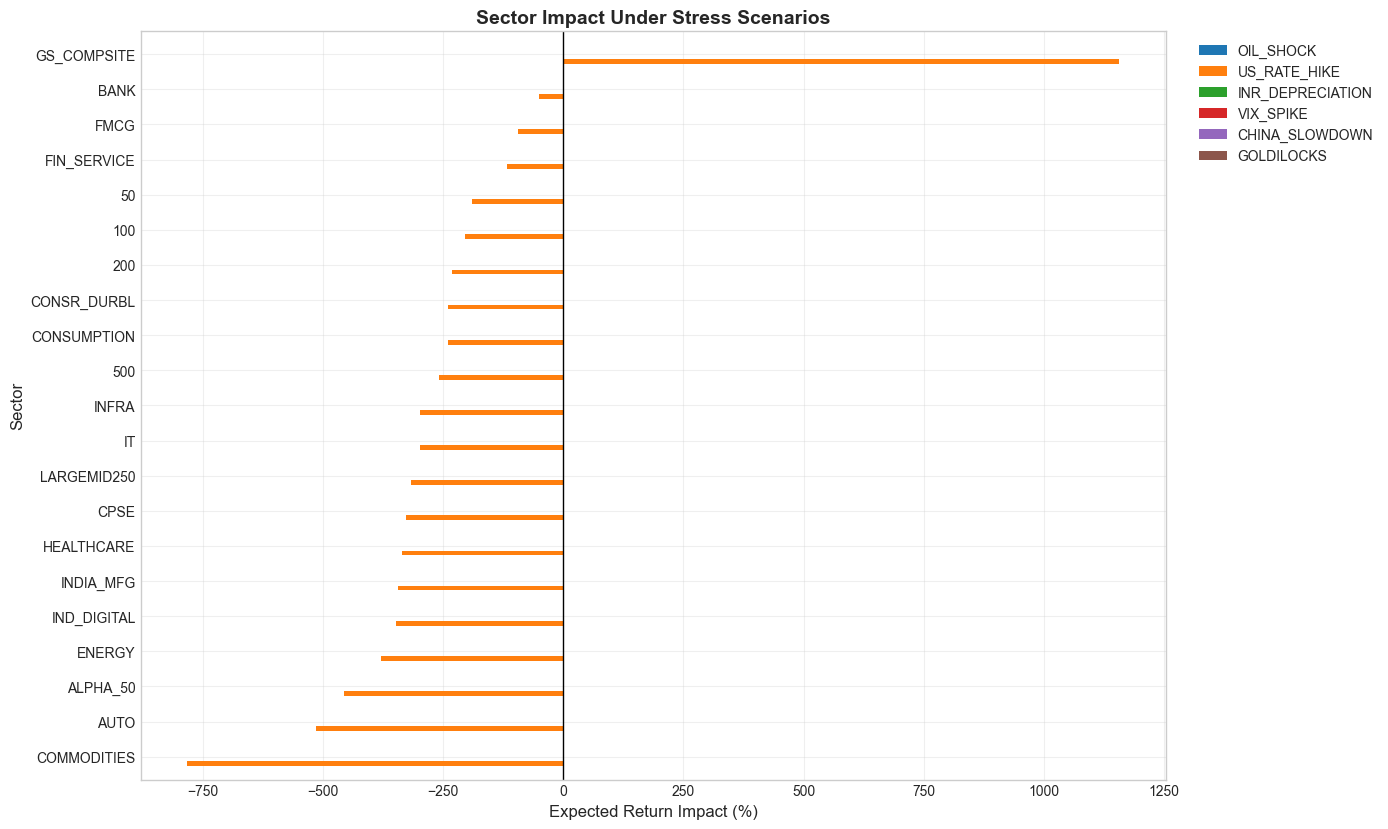

✓ Saved: scenario_impact_chart.png


In [4]:
if scenario_impacts:
    # Create impact DataFrame
    impact_df = pd.DataFrame(scenario_impacts)
    
    # Sort by worst case (most negative total)
    impact_df['worst_case'] = impact_df.min(axis=1)
    impact_df = impact_df.sort_values('worst_case')
    impact_df = impact_df.drop('worst_case', axis=1)
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, max(8, len(impact_df) * 0.4)))
    
    impact_df.plot(kind='barh', ax=ax, width=0.8)
    
    ax.axvline(x=0, color='black', linewidth=1)
    ax.set_xlabel('Expected Return Impact (%)', fontsize=12)
    ax.set_ylabel('Sector', fontsize=12)
    ax.set_title('Sector Impact Under Stress Scenarios', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PROCESSED_PATH / 'scenario_impact_chart.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Saved: scenario_impact_chart.png")

## 4. Scenario Summary Table

In [5]:
if scenario_impacts:
    print("\n📊 SCENARIO STRESS TEST SUMMARY")
    print("="*70)
    
    for scenario_name, scenario in STRESS_SCENARIOS.items():
        impact = scenario_impacts[scenario_name]
        
        # Top winners and losers
        winners = impact.nlargest(3)
        losers = impact.nsmallest(3)
        
        print(f"\n{scenario_name}: {scenario['description']}")
        print(f"  Historical example: {scenario['historical_example']}")
        print(f"  🏆 Winners: {', '.join([f'{s} ({v:+.1f}%)' for s, v in winners.items()])}")
        print(f"  📉 Losers: {', '.join([f'{s} ({v:+.1f}%)' for s, v in losers.items()])}")


📊 SCENARIO STRESS TEST SUMMARY

OIL_SHOCK: Brent crude +10%
  Historical example: Russia-Ukraine 2022
  🏆 Winners: GS_COMPSITE (+0.0%), COMMODITIES (+0.0%), ALPHA_50 (+0.0%)
  📉 Losers: GS_COMPSITE (+0.0%), COMMODITIES (+0.0%), ALPHA_50 (+0.0%)

US_RATE_HIKE: US 10Y yield +100 bps
  Historical example: 2022 Fed tightening
  🏆 Winners: GS_COMPSITE (+1156.1%), BANK (-50.4%), FMCG (-93.8%)
  📉 Losers: COMMODITIES (-782.3%), AUTO (-514.8%), ALPHA_50 (-455.5%)

INR_DEPRECIATION: INR depreciates 5% vs USD
  Historical example: Taper tantrum 2013
  🏆 Winners: GS_COMPSITE (+0.0%), COMMODITIES (+0.0%), ALPHA_50 (+0.0%)
  📉 Losers: GS_COMPSITE (+0.0%), COMMODITIES (+0.0%), ALPHA_50 (+0.0%)

VIX_SPIKE: VIX jumps to 35 (risk-off)
  Historical example: COVID crash Mar 2020
  🏆 Winners: GS_COMPSITE (+0.0%), COMMODITIES (+0.0%), ALPHA_50 (+0.0%)
  📉 Losers: GS_COMPSITE (+0.0%), COMMODITIES (+0.0%), ALPHA_50 (+0.0%)

CHINA_SLOWDOWN: China CSI 300 -15%, Copper -10%
  Historical example: 2015 China dev

## 5. Portfolio Stress Test

In [6]:
# Example portfolio
EXAMPLE_PORTFOLIO = {
    'BANK': 0.20,
    'IT': 0.15,
    'AUTO': 0.10,
    'FMCG': 0.10,
    'PHARMA': 0.10,
    'INFRA': 0.10,
    'COMMODITIES': 0.05,
    'ENERGY': 0.05,
    'FIN_SERVICE': 0.10,
    'HEALTHCARE': 0.05
}

if scenario_impacts:
    print("\n💼 PORTFOLIO STRESS TEST RESULTS")
    print("="*50)
    
    portfolio_impacts = {}
    
    for scenario_name, impact in scenario_impacts.items():
        portfolio_return = 0
        for sector, weight in EXAMPLE_PORTFOLIO.items():
            if sector in impact.index:
                portfolio_return += weight * impact[sector]
        
        portfolio_impacts[scenario_name] = portfolio_return
        
        emoji = '🟢' if portfolio_return > 0 else '🔴' if portfolio_return < -5 else '🟡'
        print(f"  {emoji} {scenario_name}: {portfolio_return:+.2f}%")
    
    # Worst case
    worst = min(portfolio_impacts, key=portfolio_impacts.get)
    print(f"\n⚠️  WORST CASE: {worst} → {portfolio_impacts[worst]:+.2f}%")


💼 PORTFOLIO STRESS TEST RESULTS
  🟡 OIL_SHOCK: +0.00%
  🔴 US_RATE_HIKE: -231.98%
  🟡 INR_DEPRECIATION: +0.00%
  🟡 VIX_SPIKE: +0.00%
  🟡 CHINA_SLOWDOWN: +0.00%
  🟢 GOLDILOCKS: +0.05%

⚠️  WORST CASE: US_RATE_HIKE → -231.98%


## 6. Hedging Recommendations

In [7]:
if scenario_impacts:
    print("\n🛡️ HEDGING RECOMMENDATIONS")
    print("="*50)
    
    # Based on worst scenarios
    for scenario_name, port_impact in sorted(portfolio_impacts.items(), key=lambda x: x[1])[:3]:
        scenario = STRESS_SCENARIOS[scenario_name]
        impact = scenario_impacts[scenario_name]
        
        print(f"\nTo hedge {scenario_name}:")
        
        # Find sectors that benefit
        beneficiaries = impact[impact > 0].nlargest(3)
        if len(beneficiaries) > 0:
            print(f"  ➕ Add exposure to: {', '.join(beneficiaries.index.tolist())}")
        
        # Find sectors to reduce
        hurt = impact[impact < -2].nsmallest(3)
        if len(hurt) > 0:
            print(f"  ➖ Reduce exposure to: {', '.join(hurt.index.tolist())}")


🛡️ HEDGING RECOMMENDATIONS

To hedge US_RATE_HIKE:
  ➕ Add exposure to: GS_COMPSITE
  ➖ Reduce exposure to: COMMODITIES, AUTO, ALPHA_50

To hedge OIL_SHOCK:

To hedge INR_DEPRECIATION:


## 7. Export Stress Test Results

In [8]:
if scenario_impacts:
    # Save impact matrix
    impact_df = pd.DataFrame(scenario_impacts)
    impact_df.to_parquet(PROCESSED_PATH / 'stress_test_impacts.parquet')
    impact_df.to_csv(PROCESSED_PATH / 'stress_test_impacts.csv')
    print("✓ Saved: stress_test_impacts.parquet/csv")
    
    # Save portfolio results
    port_df = pd.DataFrame([
        {'scenario': k, 'portfolio_impact_%': v}
        for k, v in portfolio_impacts.items()
    ])
    port_df.to_parquet(PROCESSED_PATH / 'portfolio_stress_results.parquet', index=False)
    print("✓ Saved: portfolio_stress_results.parquet")

✓ Saved: stress_test_impacts.parquet/csv
✓ Saved: portfolio_stress_results.parquet


## 8. Key Outputs ✓

### Stress Test Summary

| Scenario | Typical Impact | Hedge |
|----------|---------------|-------|
| Oil +10% | Importers hurt | Reduce Auto, Add Energy |
| US Rates +100bps | EM outflows | Reduce duration, Add defensives |
| INR -5% | IT benefits, importers hurt | Add IT, Reduce Auto |
| VIX spike | All risk-off | Cash, reduce beta |

### Outputs
- `stress_test_impacts.parquet` — Sector impacts per scenario
- `portfolio_stress_results.parquet` — Portfolio-level stress test
- `scenario_impact_chart.png` — Visualization

**LAYER 5 PORTFOLIO & RISK COMPLETE**

**Next notebook:** `06_macro_dashboard_streamlit.ipynb`